In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from IPython.display import clear_output
from numba import jit,njit, cuda
import cv2

In [2]:
for i in range(0,5,1):
    print(i)

0
1
2
3
4


# "Particle" Class
A class which describes the properties of a particle.

In [2]:
class Particle():
    """
    x_pos = Position of Particle on x-axis.
    y_pos = Position of Particle on y-axis.
    vx = X-component of Velocity.
    vy = Y-component of Velocity.
    ax = X-component of Acceleration
    ay = Y-component of Acceleration
    colour = Colour of the particle
    """
    def __init__(self, x_pos, y_pos, colour, vx=0, vy=0, ax=0, ay=0):

        self.x = x_pos
        self.y = y_pos
        self.vx = vx
        self.vy = vy
        self.ax = ax
        self.ay = ay
        self.colour = colour

# "Create" class
A class to create multiple particles and assign random positions

In [3]:
class Create():
    """
        A class used to create particles with a particular colour.
        For example: 
                    green = Create(100, 'green')
        This will create 100 green coloured particles with random positions
                    
        Attributes:
        num = number of particles
        colour = colour of particles (e.g. 'green') (**string format**)
        x_limit = Range of x. (e.g. x_limit = 100 implies a range from 0 to 100 on x-axis)
        y_limit = Range of y. (e.g. y_limit = 220 implies a range from - to 220 on y-axis)
        """
    def __init__(self, num, colour, x_limit, y_limit):
        # size is the number of particle present.
        self.size = num
        self.colour = colour
        self.x_limit = x_limit
        self.y_limit = y_limit
        self.particle_list = self.create()
        self.update()
    
                
    def create(self):
        # Creating an empty list to store particles.
        particle_list = []

        # Running a loop to generate particles:
        for i in range(self.size):
            # random x (integer between '0 to x_limit')
            ran_x = np.random.randint(0, self.x_limit)
            # random y (integer between '0 to y_limit')
            ran_y = np.random.randint(0, self.y_limit)
            
            # Creating a particle
            particle = Particle(x_pos=ran_x, y_pos=ran_y,colour=self.colour)
            
            # Addiing the particle in the list.
            particle_list.append(particle)
        # Returning the list
        
        #**Note: Particle velocity and acceleration are not updated and =0**
        return particle_list
    
    def update(self):
        """
        Updates the position, velocity and acceleration of all particles."""
        # x and y component of positions of all particles
        self.x = [p.x for p in self.particle_list]
        self.y = [p.y for p in self.particle_list]
        
        # x and y velocity component of all particles
        self.vx = [p.vx for p in self.particle_list]
        self.vy = [p.vy for p in self.particle_list]
        
        # x and y acceleration component of all particles
        self.ax = [p.ax for p in self.particle_list]
        self.ay = [p.ay for p in self.particle_list]
        
    def plot(self, ax= None):
        """
        Plots the particles"""
        
        # Before plotting, update the properties of the particles
        self.update()
        
        x_list, y_list, col = self.x, self.y, self.colour
        
        if ax is None:
            plt.scatter(x_list, y_list,c=col,s=5,alpha=0.6, linewidth=0.2)
        else:
            ax.scatter(x_list, y_list,c=col,s=5,alpha=0.6,linewidth=0.2)

In [4]:
@jit
def rule(particle1, particle2, force=10):
    """
    Takes two objects of 'Create' class.
    For example:
    
        ```
        green = Create(10, 'green', x_limit=100, y_limit=100)
        red = Create(10,'red',x_limit=100,y_limit=100)
        
        rule(green, red, force=0.1)
        # force = +ve => repulsive force
        # force = -ve => attractive force
        ```
        ### **Note**: only "green" particles will have their positions updated.
                     If you want to update the properties of red particles then
                     use :
                     `rule(red,green,force=-0.1)
                     `
                     This will attract red particles towards green particles
                
        
        ########
        particle1: any object from 'Create' class
        particle2: any object from 'Create' class
        force: force acting between the two particle objects.
        """
    for i in range(particle1.size):
        particle1.particle_list[i].ax = 0
        particle1.particle_list[i].ay = 0
        for j in range(particle2.size):
            a = particle1.particle_list[i]
            b = particle2.particle_list[j]
            dx = a.x - b.x
            dy = a.y - b.y
            d = np.sqrt(dx**2 + dy**2)
            if d>0 and d<(0.16*particle1.x_limit):
                # increase dt to speed up algorithm
                dt = 0.5
                F = force*1/d*dt
                a.ax += (F*dx)
                a.ay += (F*dy)
                
        a.vx = (a.vx + a.ax)*0.5
        a.vy = (a.vy + a.ay)*0.5
        a.x += a.vx
        a.y += a.vy
        particle1.particle_list[i] = a
        
        # Boundary condition
        if a.x <= 0 or a.x >= particle1.x_limit:
            a.vx *= -1
        if a.y <= 0 or a.y >= particle1.x_limit:
            a.vy *= -1

# Function to save videos

In [5]:
# Use this function after the images are saved to a particular folder.

# Always use numbers to name the image files, no alphabets should be there in the names.
def save_to_video(video_name:'str',image_folder='folder_path_where_your_images_saved', fps=30):
    '''
    Example:
    save_to_video(video_name='galaxy_sim2.mp4',image_folder="./animation_dump/",fps=30)'''
    print('Video starting to process')
    # gather the names of the images in the folder:
    images = [img for img in os.listdir(image_folder) if img.endswith('.png')]
    
    # sort the images number wise.
    images = sorted(images, key=lambda x: int(os.path.splitext(x)[0]))
    #if you have used alphabets in the order 'image_01.png'
    # Use:
    #images = sorted(images, key=lambda x: int(x.splitext(x.split('_')[-1])[0])) check the below rough work.
    
    # Convert any image into array and check the dimensions of data type:
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    print(frame.shape)
    height, width, layers = frame.shape #(height, width, color channels)
    
    # Video codec, etc settings ('DIVX best for windows' source:https://docs.opencv.org/master/dd/d43/tutorial_py_video_display.html)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    '''**Note**: This fourcc will work for both Mac and Windows users. '''
    
    # Create the video object from cv2 with appropriate arguments:
    video = cv2.VideoWriter(video_name, fourcc, fps, (width,height))
    print('Video is processing...')
    # Add image from the images
    for image in images:
        # Join the name of the image to full path directory and convert the image into array and add it to the video file.
        video.write(cv2.imread(os.path.join(image_folder, image)))
    
    # Destroying cv2 windows (safety protocol)
    cv2.destroyAllWindows()
    print(f"Video Processed\nSaved in as '{video_name}'.")
    #Upload the video at desired path:
    video.release()

# Creating Life Patterns

### Example 1


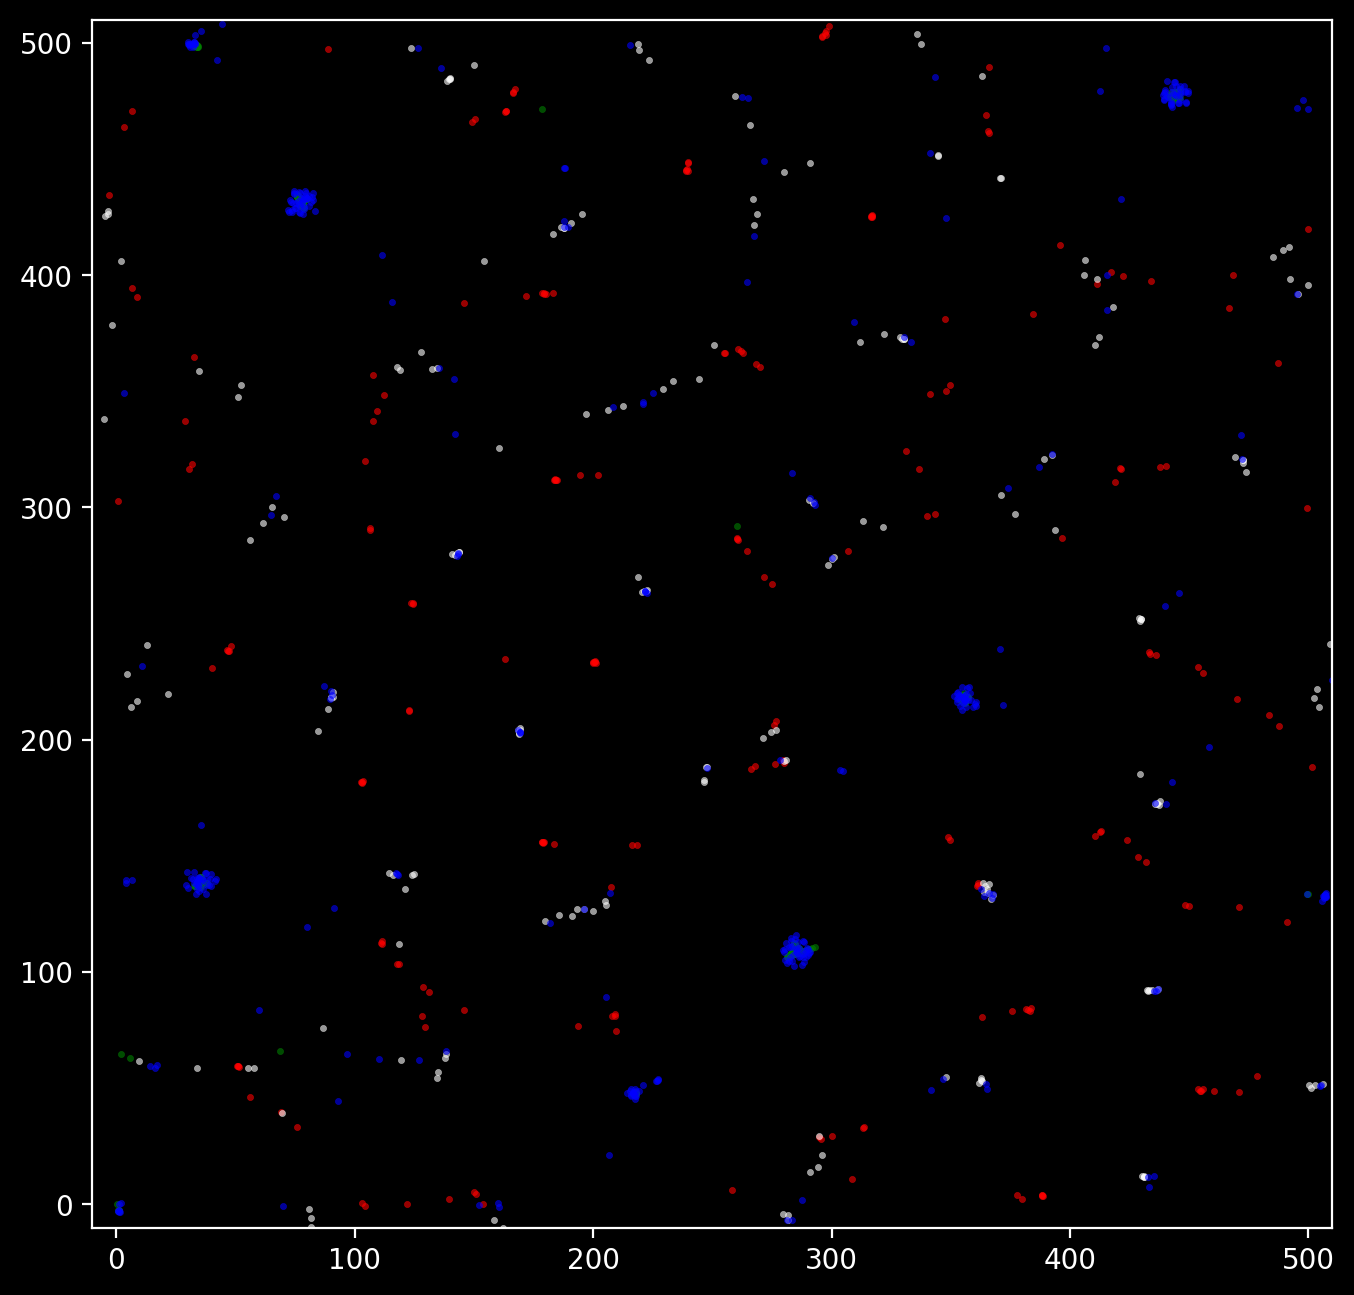

100.0% rendered...


In [8]:
# We set the x and y limit for the plot:
x_lim = 500
y_lim = 500

# Creating 'Create' objects 
green = Create(num = 500, colour='green',x_limit=x_lim, y_limit=y_lim)
red = Create(num = 500, colour='red',x_limit=x_lim,y_limit=y_lim)
white = Create(num=500,colour='white',x_limit=x_lim,y_limit=y_lim)
blue = Create(num=500,colour='blue',x_limit=x_lim,y_limit=y_lim)

# time loop
time_steps = 1200
for i in range(time_steps):
    fig, ax = plt.subplots(1,1,figsize=(8,8),dpi=200)
    # plotting the particles
    green.plot(ax)
    red.plot(ax)
    white.plot(ax)
    blue.plot(ax)
    # force = +ve => repulsive force
    # force = -ve => attractive force
    # applying rules
    rule(green, red, force=0.2)
    rule(green,green,force=0.1)
    rule(green,white,force=-0.10)
    rule(green,blue,force=-0.30)
    #
    rule(red, green, force = 0.1)
    rule(red,red, force=0.5)
    rule(red, white, force=-0.25)
    rule(red,blue, force=-0.10)
    #
    rule(white,green,force=0.4)
    rule(white,white,force=0.5)
    rule(white,red,force=-0.10)
    rule(white,blue,force=-0.20)
    #
    rule(blue,green,force=-0.20)
    rule(blue,red,force=-0.30)
    rule(blue,white,force=0.60)
    rule(blue,blue,force=0.5)
    
    # setting x limits (for plotting)
    ax.set_xlim(0-10,x_lim+10)
    ax.set_ylim(0-10,y_lim+10)
    
    # for saving video:
    plt.savefig(f'animation_dump/{i}.png')
    plt.show()
    print(f"{((i+1)/time_steps)*100}% rendered...")
    clear_output(wait=True)

## Saving a video

In [9]:
save_to_video(video_name='./demo15.mp4',image_folder='animation_dump/',fps=10)

Video starting to process
(1600, 1600, 3)
Video is processing...
Video Processed
Saved in as './demo15.mp4'.
